# Detection of COVID-19 using chest X-Ray


This project aims to leverage chest X-ray images to develop a predictive model for COVID-19 diagnosis. By analyzing the characteristics and patterns observed in these images, the model seeks to accurately predict whether a patient is diagnosed with COVID-19. The proposed approach offers the potential for a faster and more accessible diagnostic method, especially in areas where RT-PCR testing resources may be limited.

## Importing the required Libraries

First we need to import the necesary libraries to implement the project.

In [2]:
import keras
import cv2, os, gc, glob

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import matplotlib.cm as cm

from tqdm import tqdm
from tensorflow.keras import layers, models

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense
from keras.optimizers import Adam as adam
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

## Getting the data

The data here is imported from Kaggle. You can followthe link to download the dataset.

https://www.kaggle.com/datasets/prashant268/chest-xray-covid19-pneumonia

In [37]:
imagePaths = []
for dirname, _, filenames in os.walk('D:/Data cs/Project/Data/'):
    for filename in filenames:
        if (filename[-3:] == 'png' or 'jpg'):
            imagePaths.append(os.path.join(dirname, filename))

In [38]:
Data = []
Target = []
resize = 100

categories = {'PNEUMONIA': 'Pneumonia', 'NORMAL': 'Normal', 'COVID19': 'COVID19'}

for imagePath in tqdm(imagePaths):
    label = imagePath.split(os.path.sep)[-2].split("/")[-1]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (resize, resize)) /255

    Data.append(image)
    Target.append(categories[label])

100%|██████████████████████████████████████████████████████████████████████████████| 6536/6536 [01:50<00:00, 58.96it/s]


C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


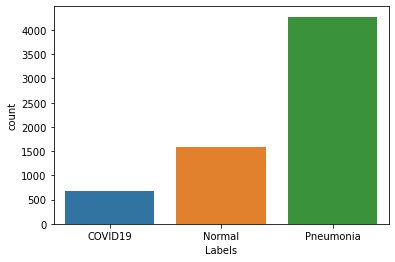

Printing Number of Images for each Category...
COVID: 676 
NORMAL: 1585 
PNEUMONIA: 4275


In [39]:
df = pd.DataFrame(Target,columns=['Labels'])
sns.countplot(df['Labels'])
plt.show()

print("Printing Number of Images for each Category..."
      '\nCOVID:',Target.count('COVID19'),
      '\nNORMAL:',Target.count('Normal'),
      '\nPNEUMONIA:',Target.count('Pneumonia'))

The Dataset consists of 6536 x-ray images and contains three sub-folders (COVID19, PNEUMONIA, NORMAL). The count of individual images of each category is shown in the plot above. The dataset consists of 676 Covid X-Rays, 1585 Normal X-Rays and 4275 Pneumonia X-Rays 

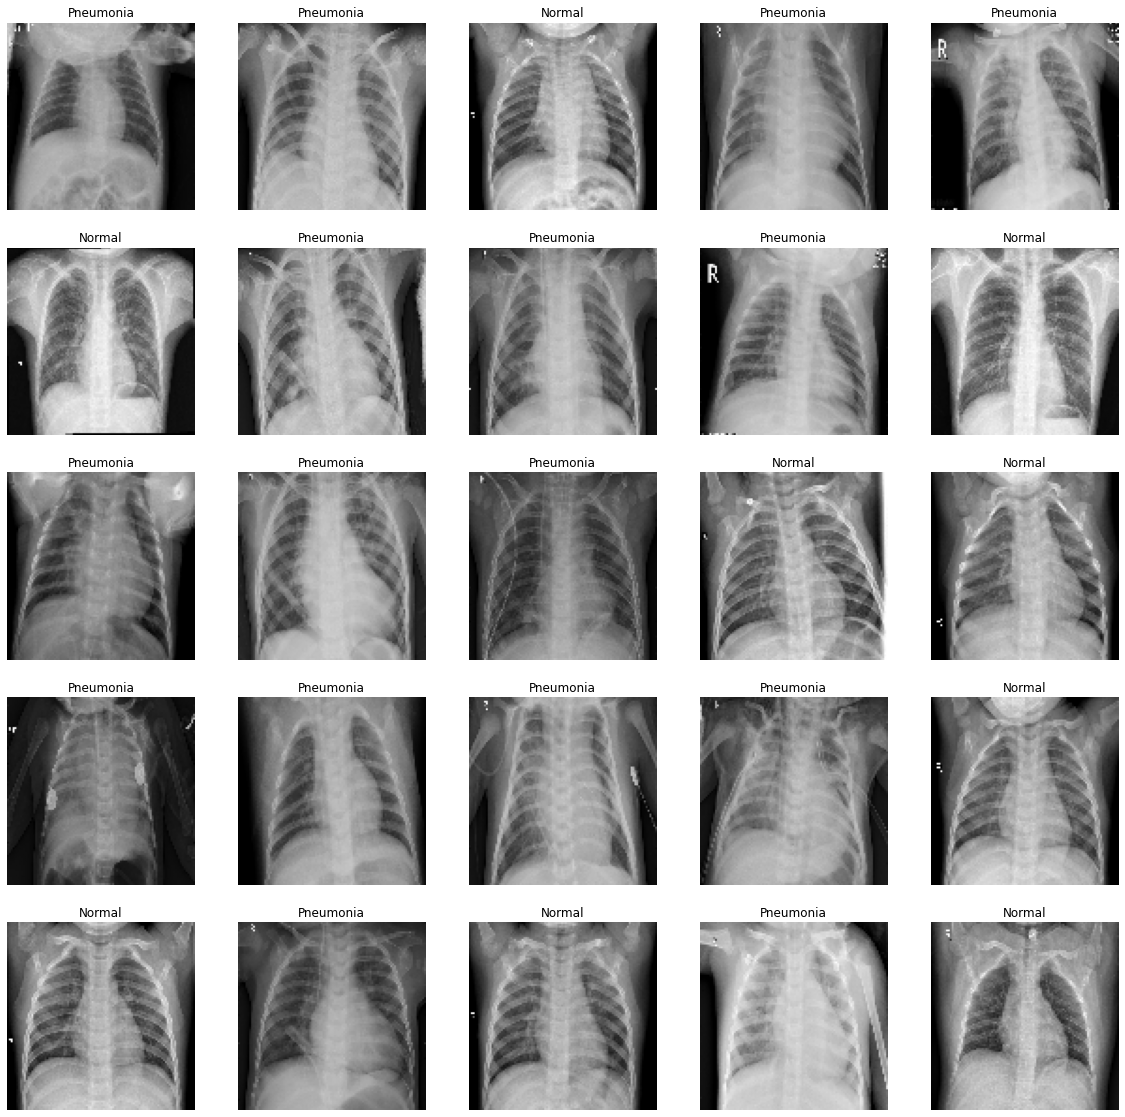

In [40]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(imagePaths),25))) : 
    plt.subplot(5,5,n+1)
    plt.imshow(Data[i] , cmap='gray')
    plt.title(Target[i])
    plt.axis('off')     
plt.show()

We can see here the different images in the dataset with their labels. The labels will help the model to learn and make predictions on the future data.

## Augmenting the Data

Data augmentation is a technique of artificially increasing the training set by creating modified copies of a dataset using existing data. It includes making minor changes to the dataset or using deep learning to generate new data points. As the dataset used here is medical we need to check if augmentation here is possible.

In [41]:
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title = ""):
    
    fig, myaxes = plt.subplots(figsize = (15, 8), nrows = 2, ncols = ncols, squeeze = False)
    fig.suptitle(main_title, fontsize = 18)
    fig.subplots_adjust(wspace = 0.3)
    fig.subplots_adjust(hspace = 0.3)
    
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize = 15)
        
    plt.show()

C:\Users\hp\AppData\Roaming\Python\Python39\site-packages\albumentations\augmentations\transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
C:\Users\hp\AppData\Roaming\Python\Python39\site-packages\albumentations\augmentations\transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


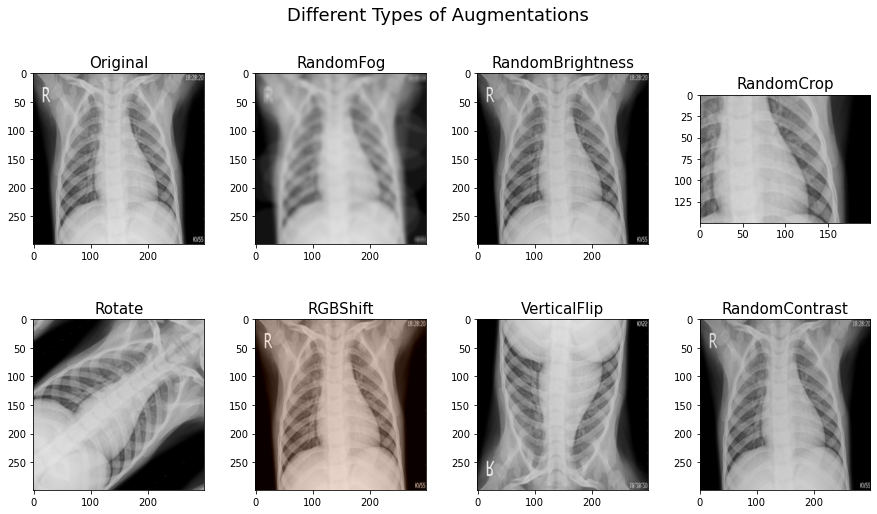

In [42]:
import albumentations as A
chosen_image = cv2.imread(imagePath)

albumentation_list = [A.RandomFog(p = 1), A.RandomBrightness(p = 1),
                      A.RandomCrop(p = 1,height = 150, width = 200), A.Rotate(p = 1, limit = 90),
                      A.RGBShift(p = 1), A.VerticalFlip(p = 1), A.RandomContrast(limit = 0.5, p = 1)]

img_matrix_list = []
bboxes_list = []
for aug_type in albumentation_list:
    img = aug_type(image = chosen_image)['image']
    img_matrix_list.append(img)

img_matrix_list.insert(0,chosen_image)    

titles_list = ["Original", "RandomFog", "RandomBrightness", "RandomCrop", "Rotate", "RGBShift", "VerticalFlip", "RandomContrast"]

plot_multiple_img(img_matrix_list, titles_list, ncols = 4, main_title = "Different Types of Augmentations")

Trying different augmentations on our data produces the results above. We can see that augmentations here can cause loss of information and won't really help in improving the model performance. 

In [65]:
le = LabelEncoder()
labels = le.fit_transform(Target)
labels = to_categorical(labels)

print(le.classes_)
print(labels[0])

['COVID19' 'Normal' 'Pneumonia']
[1. 0. 0.]


## Splitting the data into train - validation - test sets

We use the sklearn train_test_split package to split the data into train - validation - test sets to provide the model.

In [66]:
(x_train, x_test, y_train, y_test) = train_test_split(Data, labels,test_size=0.20,
                                                      stratify=labels,random_state=123)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 123)

trainX = np.array(x_train)
testX = np.array(x_test)
trainY = np.array(y_train)
testY = np.array(y_test)
valX = np.array(x_val)
valY = np.array(y_val)

print(trainX.shape)
print(valX.shape)
print(testX.shape)
print(trainY.shape)
print(valY.shape)
print(testY.shape)

(4705, 100, 100, 3)
(523, 100, 100, 3)
(1308, 100, 100, 3)
(4705, 3)
(523, 3)
(1308, 3)


## Model Building

Finally we design the model which will help us make the predictions. For this project, we have used keras and tensorflow to design our model

In [67]:
model = Sequential()

#CNN Layers
model.add(Conv2D(filters = 32, kernel_size =(3,3), activation = "relu", input_shape=(100,100,3), kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 64, kernel_size =(3,3), activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 128, kernel_size =(3,3), activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides=(1,1)))

model.add(Dropout(0.25))

#fully connected
model.add(Flatten())
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(3, activation = "softmax"))

This model is designed for automatic COVID-19 detection using raw chest X-ray
images. The model uses three convolutional layers with an input shape of (100,
100, 3) and Rectified Linear Unit (ReLU) activation function to introduce nonlinearity
in the model. The first layer has 32 filters to convolve over the input image.
It also employs dropout and L2 regularization techniques to improve generalization
and prevent overfitting. In the final dense layer, the softmax activation function is
used to obtain the class probabilities for multi-class classification.

## Model Compiling and Training

The model is compiled using the Adam optimizer and cross_categorical entropy loss function. The summary here gives us an idea of the shape of each layer and the no. of parameters to be trained at each layer. The total parameters that will be trained by the model are 3370307

In [68]:
model.compile(optimizer = adam(),
              loss= keras.losses.categorical_crossentropy,
              metrics= ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 20, 20, 128)       0

In [69]:
epochs = 50
cnn = model.fit(trainX, trainY, validation_data = (valX, valY), epochs=epochs,
                      batch_size=32,  verbose = 1)

Epoch 1/50
148/148 [==============================] - 32s 205ms/step - loss: 0.5191 - accuracy: 0.7979 - val_loss: 0.3097 - val_accuracy: 0.8948
Epoch 2/50
148/148 [==============================] - 26s 176ms/step - loss: 0.2713 - accuracy: 0.9124 - val_loss: 0.2032 - val_accuracy: 0.9331
Epoch 3/50
148/148 [==============================] - 25s 168ms/step - loss: 0.2287 - accuracy: 0.9352 - val_loss: 0.2228 - val_accuracy: 0.9331
Epoch 4/50
148/148 [==============================] - 25s 172ms/step - loss: 0.1963 - accuracy: 0.9416 - val_loss: 0.3239 - val_accuracy: 0.8700
Epoch 5/50
148/148 [==============================] - 27s 185ms/step - loss: 0.2077 - accuracy: 0.9360 - val_loss: 0.1884 - val_accuracy: 0.9484
Epoch 6/50
148/148 [==============================] - 30s 196ms/step - loss: 0.1731 - accuracy: 0.9471 - val_loss: 0.1769 - val_accuracy: 0.9484
Epoch 7/50
148/148 [==============================] - 26s 177ms/step - loss: 0.1453 - accuracy: 0.9583 - val_loss: 0.1897 - val_ac

We fit the model with 50 epochs and a batch size of 32.

## Model Accuracy and Prediction

For classification tasks like this one, you can use metrics such as accuracy, precision, recall, F1-score, or confusion matrix. These metrics can help you quantify how well your CNN models fit the data and generalize to new data.

In [70]:
modelLoss, modelAccuracy = model.evaluate(testX, testY, verbose=0)

print('Test Loss is {}'.format(modelLoss))
print('Test Accuracy is {}'.format(modelAccuracy ))

class_names = ['COVID19','NORMAL','PNEUMONIA']

y_pred = model.predict(testX)
print(class_names[np.argmax(y_pred[1])])

Test Loss is 0.19964146614074707
Test Accuracy is 0.9541284441947937
41/41 [==============================] - 1s 31ms/step
PNEUMONIA


The accuracy for the test data is 0.9541284441947937 indicating that the model can give correct predictions 95.4 times out of 100

## Classification Report

To find the accoracy of the model in predicting the individual classes, we use the classification report. We calculate the classification report for each train, validation and test sets to get an idea of how well the model has performed in each set.

In [71]:
batch_size=32

predIdxs = model.predict (trainX, batch_size=batch_size)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(trainY.argmax(axis=1), predIdxs, target_names=le.classes_, digits = 5))

148/148 [==============================] - 5s 32ms/step
              precision    recall  f1-score   support

     COVID19    1.00000   1.00000   1.00000       475
      Normal    1.00000   1.00000   1.00000      1159
   Pneumonia    1.00000   1.00000   1.00000      3071

    accuracy                        1.00000      4705
   macro avg    1.00000   1.00000   1.00000      4705
weighted avg    1.00000   1.00000   1.00000      4705



In [72]:
predIdxs = model.predict (valX, batch_size=batch_size)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(valY.argmax(axis=1), predIdxs, target_names=le.classes_, digits = 5))

17/17 [==============================] - 1s 31ms/step
              precision    recall  f1-score   support

     COVID19    0.95312   0.92424   0.93846        66
      Normal    0.92857   0.95413   0.94118       109
   Pneumonia    0.97118   0.96839   0.96978       348

    accuracy                        0.95985       523
   macro avg    0.95096   0.94892   0.94981       523
weighted avg    0.96002   0.95985   0.95987       523



In [73]:
predIdxs = model.predict(testX, batch_size=batch_size)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=le.classes_, digits = 5))

41/41 [==============================] - 1s 33ms/step
              precision    recall  f1-score   support

     COVID19    0.96296   0.96296   0.96296       135
      Normal    0.91772   0.91483   0.91627       317
   Pneumonia    0.96616   0.96729   0.96673       856

    accuracy                        0.95413      1308
   macro avg    0.94895   0.94836   0.94865      1308
weighted avg    0.95409   0.95413   0.95411      1308



We are interested in the F1 score of the model. This score
provides the balance between precision and recall or in other words it is the accuracy
for individual class. From the output below, we can see the overall accuracy is 95.9%
for validation and 95.4% for test data. The support count for each class represents
the number of images on which the model training and testing was performed.

## Confusion matrix

To analyze the model classification we look into the Confusion matrix of our proposed
model. We can see that the sensitivity (Recall) of Covid-19 (96.2%) is at par with
sensitivity of Pneumonia (96.7%). Due to the fatality of the problem in hand, we aim
to focus on the False Negatives of the model which is only 2 case out of the total
dataset. This is likely due to the overlapping imaging characteristics.

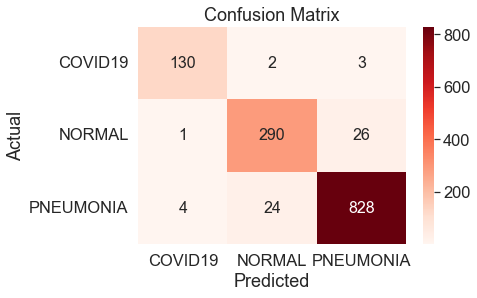

In [74]:
x = confusion_matrix(testY.argmax(axis=1),y_pred.argmax(axis=1))
Confusion_Matrix = pd.DataFrame(x, index=class_names, columns=class_names)

sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(Confusion_Matrix, annot=True, annot_kws={'size':16}, fmt='d', cmap='Reds')

plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title('Confusion Matrix')
plt.show()

## Model Saving

We save the trained model asa h5 file. This includes the weights of each layer which can be recalled without using the time and resources in training the model again

In [75]:
model.save('D:/Data cs/Project/covid19_model.h5')

C:\Users\hp\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [76]:
model = tf.keras.saving.load_model("D:/Data cs/Project/covid19_model.h5")

In [77]:
print(cnn.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


## Accuracy and Loss Graphs

Learning Curves can be really important in understanding the model function. By examining both the loss and accuracy curves, you can gain insights into how well your model is learning, whether it's overfitting or underfitting, and when it's time to stop training to prevent performance degradation on unseen data. Monitoring these curves is crucial for understanding your model's progress and making informed decisions about hyperparameters and training strategies.

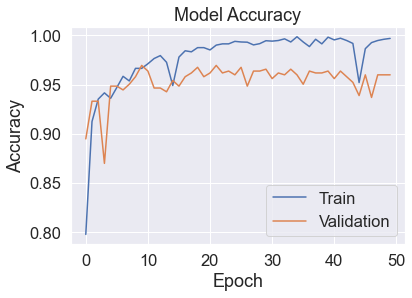

In [78]:
plt.plot(cnn.history['accuracy'])
plt.plot(cnn.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

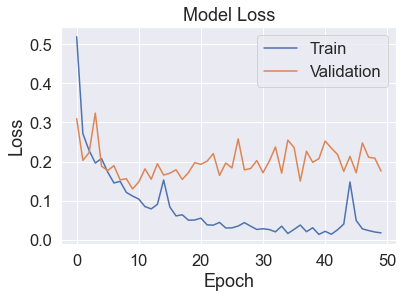

In [79]:
plt.plot(cnn.history['loss'])
plt.plot(cnn.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

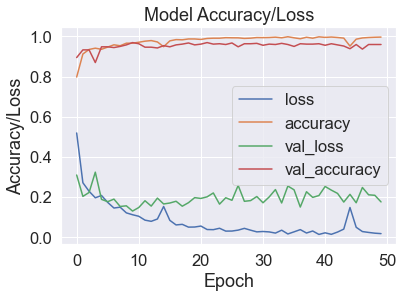

In [80]:
pd.DataFrame(cnn.history).plot()
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.show()

The learning curves show that the model is able to generalize the data and there is no case of underfitting or overfitting.

## Grad Cam Visualisation

Given the severity of the issue at hand, it is imperative that we create a visualization
of the scare tissue presence. Gradient-wighted Class Activation Mapping uses the
gradients from any target convolutional layer to create a local map which highlights
important feature that the model has learned.The images on the left column are the
actual input images of chest X-ray. heatmap of class activation is then generated
from the image based on the detected features from the image. Finally, the heatmap
is superimposed on the actual image to clearly show the presence of the COVID-19
scare tissue on the X-ray image.

In [59]:
img_path = ["D:/Data cs/Project/Data/train/COVID19/COVID-2.png",
           "D:/Data cs/Project/Data/train/COVID19/COVID-4.png",
            "D:/Data cs/Project/Data/train/NORMAL/Normal-1.png",
            "D:/Data cs/Project/Data/train/NORMAL/Normal-2.png",
           "D:/Data cs/Project/Data/train/PNEUMONIA/Pneumonia-1.png",
           "D:/Data cs/Project/Data/train/PNEUMONIA/Pneumonia-2.png"]

In [60]:
def get_img_array(img_path, size):
    img = cv2.imread(img_path)
    image = cv2.resize(img, (resize, resize))
    array = keras.preprocessing.image.img_to_array(image) 
    array = np.expand_dims(array, axis = 0)
    return array

# Top create heatmaps for the samples

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index = None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [61]:
model_builder = keras.applications.xception.Xception
img_size = (100, 100)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions
imag = []

last_conv_layer_name = "conv2d_43"

In [62]:
# Storing Heatmap values into list

covid_noncovid_heatmap = []

for i in img_path:
    img_array = preprocess_input(get_img_array(i, size = img_size))
    model = model
    preds = model.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    covid_noncovid_heatmap.append(heatmap)

1/1 [==============================] - 0s 38ms/step


In [63]:
def save_and_display_gradcam(img_path, heatmap, cam_path = "cam.jpg", alpha = 0.4):
    img = cv2.imread(img_path)
    img = keras.preprocessing.image.img_to_array(img)
    
    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    
    imag.append(cv2.imread(img_path))
    imag.append(cv2.imread("./cam.jpg"))


for i in range(len(img_path)):
    save_and_display_gradcam(img_path[i], covid_noncovid_heatmap[i])

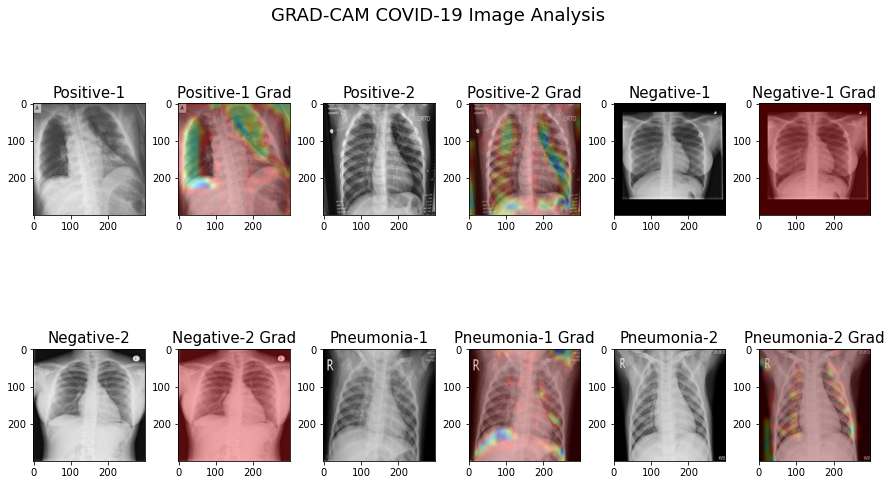

In [64]:
titles_list = ["Positive-1",'Positive-1 Grad','Positive-2','Positive-2 Grad','Negative-1','Negative-1 Grad','Negative-2','Negative-2 Grad',
              'Pneumonia-1','Pneumonia-1 Grad','Pneumonia-2','Pneumonia-2 Grad']

plot_multiple_img(imag, titles_list, ncols = 6, main_title = "GRAD-CAM COVID-19 Image Analysis")

The high-intensity visuals (blue and green) reflects the area of interest to our model
at the time of prediction